# Analyzing nutritional values with Python

**PROJECT STILL UNDER DEVELOPMENT**

## Introduction

 - Aim: visual description of food in personal diet;
 - The dataset: fppds_dataset.csv, data I collected myself from packages or via online research, so to obtain a dataset tailored to my eatinh habits;
 - Prior expectations: clusterings and superfoods
 - Principle: only collect the data in the dataset, edit here

## To Do

 - Add categories, compare expectation vs reality

## Exploring and cleaning the data

In [263]:
import pandas as pd

dataset = 'foods_dataset.csv'
df = pd.read_csv(dataset)
display(df.head())
display(df.info())
display(df.columns)

,Name,Category_1,Category_2,Portion_size_g,Portion_size_ml,Calories,Carbs,Fat,Protein,Fiber,Package_sz_g,Package_sz_ml,Source,Brand,Description
0,Flour 0,0,NaN,0.3,NaN,338.0,71.0,1.0,10.0,2.5,1000.0,NaN,Package,Coop,Farina di grano tenero
1,Flour 00,0,NaN,0.3,NaN,340.0,74.0,1.0,9.0,2.0,1000.0,NaN,MyFitnesspal,Coop,NaN
2,Whole wheat flour,0,NaN,0.3,NaN,362.0,71.0,2.0,12.0,7.0,1000.0,NaN,MyFitnesspal,Coop Vivi verdi,NaN
3,Potatoes,0,NaN,2.0,NaN,110.0,26.0,0.0,3.0,2.0,NaN,NaN,MyFitnesspal,NaN,NaN
4,Pasta,0,NaN,1.2,NaN,351.0,70.0,1.0,14.0,3.0,500.0,NaN,MyFitnesspal,La Molisana,Spaghetti quadrati


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 15 columns):
Name               135 non-null object
Category_1         135 non-null int64
Category_2         0 non-null float64
Portion_size_g     128 non-null float64
Portion_size_ml    3 non-null float64
Calories           134 non-null float64
Carbs              133 non-null float64
Fat                133 non-null float64
Protein            134 non-null float64
Fiber              67 non-null float64
Package_sz_g       32 non-null float64
Package_sz_ml      6 non-null float64
Source             134 non-null object
Brand              53 non-null object
Description        77 non-null object
dtypes: float64(10), int64(1), object(4)
memory usage: 15.9+ KB


None

Index(['Name', 'Category_1', 'Category_2', 'Portion_size_g', 'Portion_size_ml',
       'Calories', 'Carbs', 'Fat', 'Protein', 'Fiber', 'Package_sz_g',
       'Package_sz_ml', 'Source', 'Brand', 'Description'],
      dtype='object')

Columns 'Category_1' and 'Category_2' are empty. Initially, I planned on labelling each food according to some priorly conceived categories such as legumes, vegetables, meat and carbohydrates-rich foods, which would constitute 'Category_1'; 'Category_2' would then create space for possible subcategories: For instance, carbohydrates-rich foods could have been divided into wheat product, rices and potatos. 

The column 'Portion_size_ml' is pretty much empty too. This column also works as a discrimant between solid foods, whose values are given w.r.t. 100 g of food, and liquid ones, such as milk and wine, with the respective values given per 100 ml. 

There are missing values for Calories, Carbs, Fat, Protein and Fibers also.

Next we select the columns we will analyze, and fix the missing data.

### Slicing the dataframe and cleaning the data

In [264]:
# Slice columns containing nutritional values
nutr_value = df[['Name', 'Category_1','Calories', 'Carbs', 'Fat', 'Protein', 'Fiber', 'Package_sz_ml']]

#Set 'Category_1' as category:
nutr_value['Category_1'] = nutr_value['Category_1'].astype('category', copy=False)
display(nutr_value.info())
display(nutr_value.head())
#display(nutr_value['Category_1'].values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 8 columns):
Name             135 non-null object
Category_1       135 non-null category
Calories         134 non-null float64
Carbs            133 non-null float64
Fat              133 non-null float64
Protein          134 non-null float64
Fiber            67 non-null float64
Package_sz_ml    6 non-null float64
dtypes: category(1), float64(6), object(1)
memory usage: 8.0+ KB


C:\Users\joaob\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


None

,Name,Category_1,Calories,Carbs,Fat,Protein,Fiber,Package_sz_ml
0,Flour 0,0,338.0,71.0,1.0,10.0,2.5,NaN
1,Flour 00,0,340.0,74.0,1.0,9.0,2.0,NaN
2,Whole wheat flour,0,362.0,71.0,2.0,12.0,7.0,NaN
3,Potatoes,0,110.0,26.0,0.0,3.0,2.0,NaN
4,Pasta,0,351.0,70.0,1.0,14.0,3.0,NaN


In [265]:
# count missing entries
display(nutr_value.isnull().sum()) 

# set Name column as index
nutr_value = nutr_value.set_index('Name')
nutr_value.index

Name               0
Category_1         0
Calories           1
Carbs              2
Fat                2
Protein            1
Fiber             68
Package_sz_ml    129
dtype: int64

Index(['Flour 0', 'Flour 00', 'Whole wheat flour', 'Potatoes', 'Pasta',
       'Carnaroli rice', 'Basmati rice', 'Manioc flour', 'Couscous', 'Orzo',
       ...
       'Champignon', 'Porcini', 'Tangerine', 'Strawberry', 'Cherry',
       'Chestnut', 'Hazelnut', 'Olive', 'Pizza margheritta', 'Polenta'],
      dtype='object', name='Name', length=135)

There are a few rows with missing values for calories, carbohydtares, fats and proteins, but many with missing values for fibers. This may be mainly because pre packed foods with a low or null amount of fiber, instead of displaying the number 0 for fibers in their nutritional values table, do not present any data at all for this feature. Therefore, we shall later subsitute missing entries for fibers with zero. As for carbohydrates, fats and proteins, it is important to specifically see which are the foods with missing data.

In [266]:
nutr_value['Fiber'].fillna(0, inplace=True)

display(nutr_value[nutr_value['Calories'].isnull()])
display(nutr_value[nutr_value['Carbs'].isnull()])
display(nutr_value[nutr_value['Fat'].isnull()])
display(nutr_value[nutr_value['Protein'].isnull()])

,Category_1,Calories,Carbs,Fat,Protein,Fiber,Package_sz_ml
Name,,,,,,,
Oister,1,NaN,NaN,NaN,NaN,0.0,NaN


,Category_1,Calories,Carbs,Fat,Protein,Fiber,Package_sz_ml
Name,,,,,,,
Lamb brain,1,122.0,NaN,9.0,10.0,0.0,NaN
Oister,1,NaN,NaN,NaN,NaN,0.0,NaN


,Category_1,Calories,Carbs,Fat,Protein,Fiber,Package_sz_ml
Name,,,,,,,
Nectarine,3,44.0,11.0,NaN,1.0,2.0,NaN
Oister,1,NaN,NaN,NaN,NaN,0.0,NaN


,Category_1,Calories,Carbs,Fat,Protein,Fiber,Package_sz_ml
Name,,,,,,,
Oister,1,NaN,NaN,NaN,NaN,0.0,NaN


Hence, the 'Oister' row is completely empty, whereas 'Lamb brain' and 'Nectarine' present missing values of carbohydrates and fats, respectively.

Since oister are not a very important part of my diet (I wish!), and I have actually eaten it only once and a long time ago, it is not worthy the effort of searching for their nutritional values online. Instead, we may just erase the row.

In [267]:
nutr_value.drop('Oister', axis=0, inplace=True)
display(nutr_value.shape)


(134, 7)

Lamb brain, however, is something I sometimes eat, and something I do appreciate, thus I believe it may be better to search for the missing value on the internet. It turns out that its carbohydrates content is very low, so we may set it as zero. 

The fat amount in nectarine, on the other hand, we set to be equal to the equivalent number for yellow peaches, since these are very similar fruits.

In [268]:
nutr_value.loc['Lamb brain', 'Carbs'] = 0
nutr_value.loc['Nectarine', 'Fat'] = nutr_value.loc['Yellow peach', 'Fat']

display(nutr_value.isnull().sum())

Category_1         0
Calories           0
Carbs              0
Fat                0
Protein            0
Fiber              0
Package_sz_ml    128
dtype: int64

### Dealing with data with different precisions

Some food packages display very precise nutritional values, with up to two decimal values. Others, however, present only integer values, which I presume are rounded approximations. In general, different sources of information used in the construction of the dataset present values with different precision. In order to compare nutrients contents of foods throughout the dataset, we shall round decimal values to integers. This approximation will not compromise the analysis in this project, as total daily consuption values of each macronutrient present a very small sensitiveness to precisions of order $10^{-1}$ or $ 10^{-2}$ in individual data.

I first introduce a function, ```check_for_decimals```, that returns the relative number of decimal values in certain columns of a dataframe. By implementing a function to do so, I was able to check the effectiveness of the .round() method (it is always better checking!).

In [269]:
# define function
def check_for_decimals(data_frame, list_of_columns):
    """returns percentage of decimal values within columns of a data frame"""
    #initialize dictionary with columns in list_of_columns as keys and 0 as values:
    number_of_decimals = dict.fromkeys(list_of_columns, 0)
    #count the number of decimal values in each column:
    for column in list_of_columns: #loop over columns
        for x in data_frame[column]: #loop over rows in the column
            if x.is_integer() == False:
                #adds 1 to the resp value in the dictionary, computes the percentage rounded to 2 decimals:
                number_of_decimals[column] = round((number_of_decimals[column] + 1)/len(column), 2)
    return number_of_decimals

columns = ['Calories', 'Carbs', 'Protein', 'Fat', 'Fiber']

#relative number of decimal values within columns in columns of nutr_value:
display(check_for_decimals(nutr_value,columns))

#round nutr_values:
nutr_value_round = nutr_value.round()

#check:
display(check_for_decimals(nutr_value_round, columns))

display(nutr_value_round.head())

{'Calories': 0, 'Carbs': 0.25, 'Protein': 0.17, 'Fat': 0.5, 'Fiber': 0.25}

{'Calories': 0, 'Carbs': 0, 'Protein': 0, 'Fat': 0, 'Fiber': 0}

,Category_1,Calories,Carbs,Fat,Protein,Fiber,Package_sz_ml
Name,,,,,,,
Flour 0,0,338.0,71.0,1.0,10.0,2.0,NaN
Flour 00,0,340.0,74.0,1.0,9.0,2.0,NaN
Whole wheat flour,0,362.0,71.0,2.0,12.0,7.0,NaN
Potatoes,0,110.0,26.0,0.0,3.0,2.0,NaN
Pasta,0,351.0,70.0,1.0,14.0,3.0,NaN


The dataset contains foods whose nutritional values are estimated w.r.t. portions of either 100g or 100ml (for liquids). It is meaningless to compare foods belonging to different categories. 

In [270]:
solid_foods = nutr_value_round[nutr_value_round['Package_sz_ml'].isnull() == True]
solid_foods.drop('Package_sz_ml', axis=1, inplace=True)

solid_foods.info()
solid_foods.head()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, Flour 0 to Polenta
Data columns (total 6 columns):
Category_1    128 non-null category
Calories      128 non-null float64
Carbs         128 non-null float64
Fat           128 non-null float64
Protein       128 non-null float64
Fiber         128 non-null float64
dtypes: category(1), float64(5)
memory usage: 6.5+ KB


C:\Users\joaob\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Category_1,Calories,Carbs,Fat,Protein,Fiber
Name,,,,,,
Flour 0,0,338.0,71.0,1.0,10.0,2.0
Flour 00,0,340.0,74.0,1.0,9.0,2.0
Whole wheat flour,0,362.0,71.0,2.0,12.0,7.0
Potatoes,0,110.0,26.0,0.0,3.0,2.0
Pasta,0,351.0,70.0,1.0,14.0,3.0


In [271]:
colors = ['purple', 'orange', 'blue', 'darkgreen', 'red']
columns_dict = dict(zip(columns, colors))
print(columns_dict)

{'Calories': 'purple', 'Carbs': 'orange', 'Protein': 'blue', 'Fat': 'darkgreen', 'Fiber': 'red'}


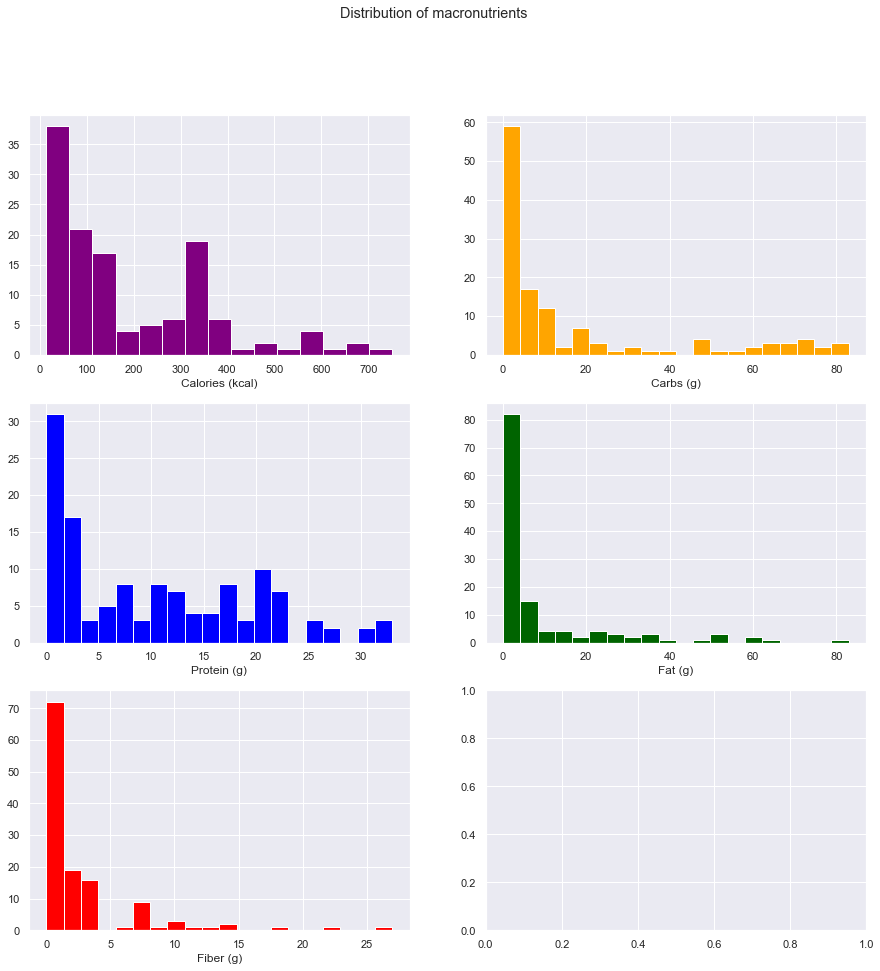

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_context('notebook')


fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(15,15))
fig.suptitle('Distribution of macronutrients')
ax1.hist(solid_foods['Calories'], bins=15, color=columns_dict['Calories'])
ax1.set(xlabel='Calories (kcal)')
ax2.hist(solid_foods['Carbs'], bins=20, color=columns_dict['Carbs'])
ax2.set(xlabel='Carbs (g)')
ax3.hist(solid_foods['Protein'], bins=20, color=columns_dict['Protein'])
ax3.set(xlabel='Protein (g)')
ax4.hist(solid_foods['Fat'], bins=20, color=columns_dict['Fat'])
ax4.set(xlabel='Fat (g)')
ax5.hist(solid_foods['Fiber'], bins=20, color=columns_dict['Fiber'])
ax5.set(xlabel='Fiber (g)')

plt.show()

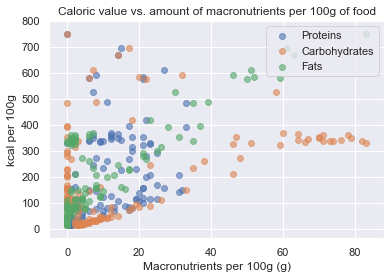

In [273]:
alpha=0.6
fig, ax = plt.subplots(sharey=True)
#ax = fig.add_subplot()
ax.set(title='Caloric value vs. amount of macronutrients per 100g of food', 
       ylabel='kcal per 100g', 
       xlabel='Macronutrients per 100g (g)')
ax1 = ax.scatter(x='Protein', y='Calories', data=solid_foods, alpha=alpha)
ax2 = ax.scatter(x='Carbs', y='Calories', data=solid_foods, alpha=alpha)
ax3 = ax.scatter(x='Fat', y='Calories', data=solid_foods, alpha=alpha)

ax.legend((ax1, ax2, ax3), ('Proteins', 'Carbohydrates', 'Fats'))
plt.show()



Limit in amount of proteins per 100g; linear dependence fat X calories

(3.137356922033249, 0.33032238175291784)


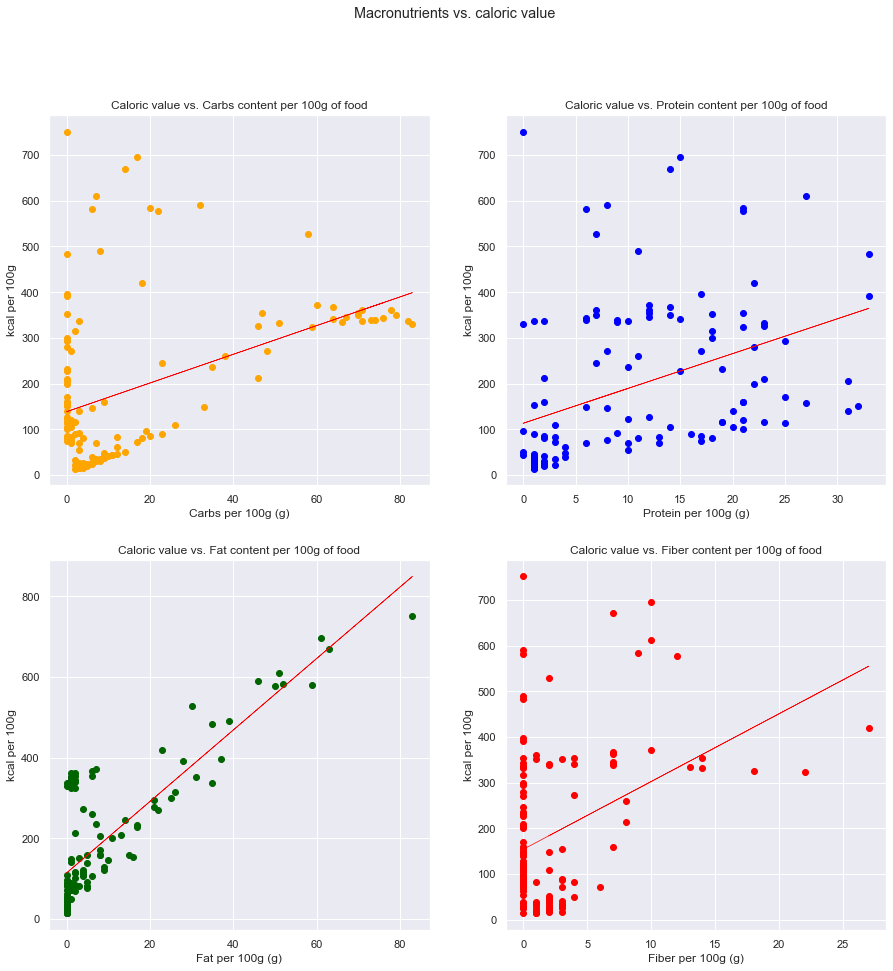

In [274]:
import numpy as np

ax = dict(zip(columns, [0,0,0,0,0]))
coef = dict(zip(columns, [0,0,0,0,0]))
fig, ((ax['Carbs'], ax['Protein']), (ax['Fat'], ax['Fiber'])) = plt.subplots(2,2, figsize=(15,15))
Y = np.array(solid_foods['Calories'])
fig.suptitle('Macronutrients vs. caloric value')

for column in columns_dict.keys():
    if column == 'Calories':
        continue
    
    else:
        X = np.array(solid_foods[column]) #numpy array for the x-axis
        p, cov = np.polyfit(X, Y, deg=1, cov=True)
        coef[column] = {'angular':(p[0], cov[0,0]), 'linear':(p[1], cov[1,1])}
        
        ax[column].scatter(x=column, y='Calories', data=solid_foods, color=columns_dict[column])
        ax[column].plot(solid_foods[column], p[0]*solid_foods[column] + p[1], 'red', linewidth=0.7)
        ax[column].set(title='Caloric value vs. '+ column +' content per 100g of food', 
                   ylabel='kcal per 100g', 
                   xlabel= column + ' per 100g (g)')
        

print(coef['Carbs']['angular'])
    
plt.show()

Aprox. 8.85 kcal per gram of fat; get uncertainty, comment b

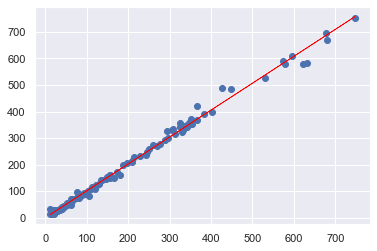

1.014154710154735 -0.24496709878439857


In [275]:
X_caloriesT = np.array(4*(solid_foods['Protein'] + solid_foods['Carbs']) + 9*solid_foods['Fat'])
#X_caloriesP = np.array(p_prot[0]*solid_foods['Protein'] + p_carbs[0]*solid_foods['Carbs'] + p_fat[0]*solid_foods['Fat'])
a_kcT, b_kcT = np.polyfit(X_caloriesT, Y, deg=1)
#a_kcP, b_kcP = np.polyfit(X_caloriesP, Y, deg=1)

plt.scatter(x=X_caloriesT, y=solid_foods['Calories'])
plt.plot(X_caloriesT, a_kcT*X_caloriesT + b_kcT, 'red', linewidth=0.7)
plt.show()

print(a_kcT, b_kcT)

#plt.scatter(x=X_caloriesP, y=solid_foods['Calories'])
#plt.plot(X_caloriesP, a_kcP*X_caloriesP + b_kcP, 'red', linewidth=0.7)
#plt.show()

#print(a_kcP, b_kcP)


## Considering portion size

In [276]:
portion_sizes = df[['Name', 'Portion_size_g']].set_index('Name')
portion_sizes.head()

solid_foods_portion = pd.merge(portion_sizes, solid_foods, on='Name', how='inner')
display(portion_sizes.shape)
display(solid_foods.shape)
display(solid_foods_portion.shape)
display(solid_foods_portion.head())

(135, 1)

(128, 6)

(128, 7)

,Portion_size_g,Category_1,Calories,Carbs,Fat,Protein,Fiber
Name,,,,,,,
Flour 0,0.3,0,338.0,71.0,1.0,10.0,2.0
Flour 00,0.3,0,340.0,74.0,1.0,9.0,2.0
Whole wheat flour,0.3,0,362.0,71.0,2.0,12.0,7.0
Potatoes,2.0,0,110.0,26.0,0.0,3.0,2.0
Pasta,1.2,0,351.0,70.0,1.0,14.0,3.0


In [277]:
for column in columns:
    solid_foods_portion[column + '_per_portion'] = solid_foods_portion[column] * solid_foods_portion['Portion_size_g']
    solid_foods_portion.drop(column, axis=1, inplace=True)
    
display(solid_foods_portion.head())

,Portion_size_g,Category_1,Calories_per_portion,Carbs_per_portion,Protein_per_portion,Fat_per_portion,Fiber_per_portion
Name,,,,,,,
Flour 0,0.3,0,101.4,21.3,3.0,0.3,0.6
Flour 00,0.3,0,102.0,22.2,2.7,0.3,0.6
Whole wheat flour,0.3,0,108.6,21.3,3.6,0.6,2.1
Potatoes,2.0,0,220.0,52.0,6.0,0.0,4.0
Pasta,1.2,0,421.2,84.0,16.8,1.2,3.6


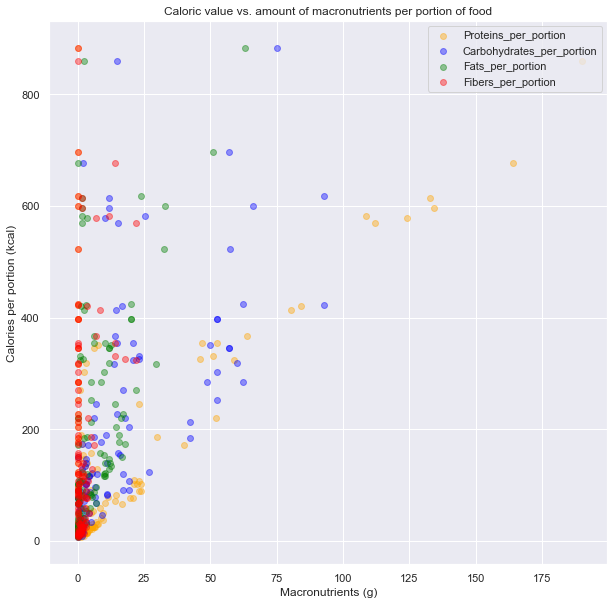

In [278]:
alpha=0.6
# fig, ax = plt.subplots(sharey=True)
# ax.set(title='Caloric value vs. amount of macronutrients per portion of food', 
#        ylabel='kcal per portion', 
#        xlabel='Macronutrients per portion (g)')
# ax1 = ax.scatter(x='Protein_per_portion', y='Calories_per_portion', data=solid_foods_portion, alpha=alpha)
# ax2 = ax.scatter(x='Carbs_per_portion', y='Calories_per_portion', data=solid_foods_portion, alpha=alpha)
# ax3 = ax.scatter(x='Fat_per_portion', y='Calories_per_portion', data=solid_foods_portion, alpha=alpha)

# ax.legend((ax1, ax2, ax3), ('Proteins_per_portion', 'Carbohydrates_per_portion', 'Fats_per_portion'))
# plt.show()

fig, ax = plt.subplots(figsize=(10,10))
for column in macronutrients_per_portion.keys():
    if column == 'Calories_per_portion':
        continue
    else:
        ax.scatter(x=column, y='Calories_per_portion', data=solid_foods_portion, alpha=0.4, color = macronutrients_per_portion[column])

ax.set(xlabel='Macronutrients (g)', ylabel='Calories per portion (kcal)', title='Caloric value vs. amount of macronutrients per portion of food')
ax.legend(('Proteins_per_portion', 'Carbohydrates_per_portion', 'Fats_per_portion', 'Fibers_per_portion'))

plt.show()

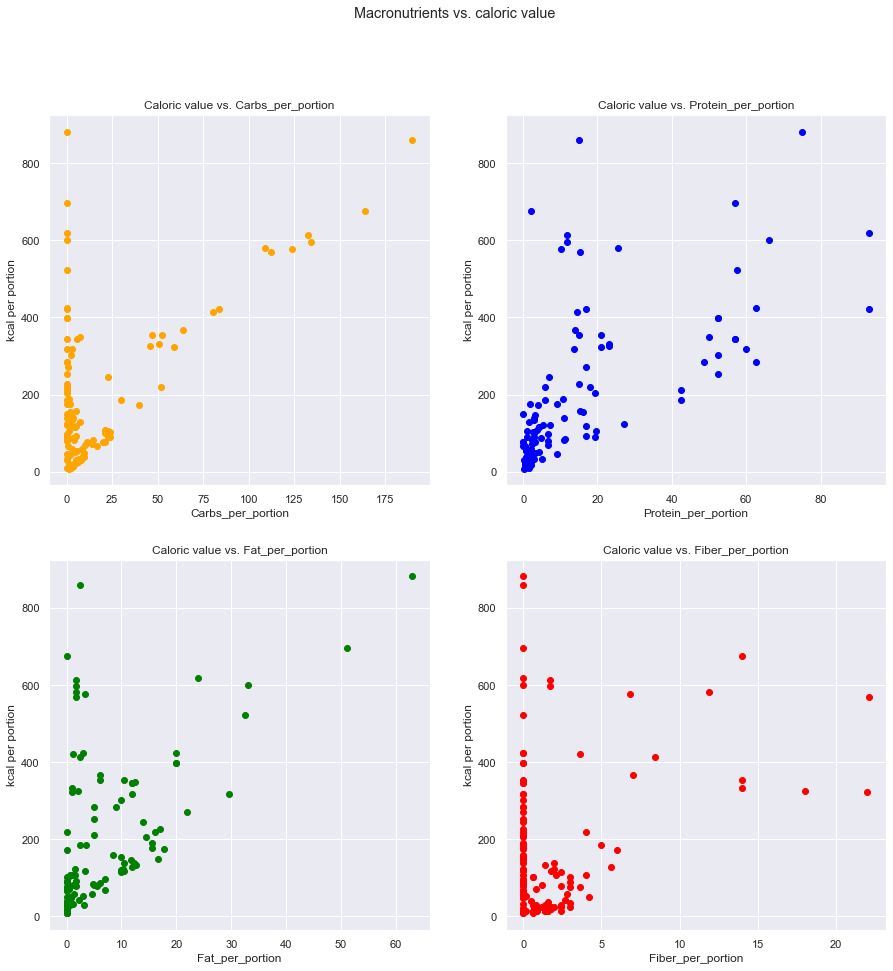

In [279]:
macronutrients_per_portion = {'Calories_per_portion':'purple', 'Carbs_per_portion':'orange', 'Protein_per_portion':'blue', 'Fat_per_portion':'green', 'Fiber_per_portion':'red'}

ax = dict(zip(macronutrients_per_portion.keys(), [0,0,0,0,0]))
# print(ax)
# coef = dict(zip(columns, [0,0,0,0,0]))
fig, ((ax['Carbs_per_portion'], ax['Protein_per_portion']), (ax['Fat_per_portion'], ax['Fiber_per_portion'])) = plt.subplots(2,2, figsize=(15,15))
# Y = np.array(solid_foods['Calories'])
fig.suptitle('Macronutrients vs. caloric value')

for column in macronutrients_per_portion.keys():
    if column == 'Calories_per_portion':
        continue
    
    else:
        #X = np.array(solid_foods[column]) #numpy array for the x-axis
        #p, cov = np.polyfit(X, Y, deg=1, cov=True)
        #coef[column] = {'angular':(p[0], cov[0,0]), 'linear':(p[1], cov[1,1])}
        
        ax[column].scatter(x=column, y='Calories_per_portion', data=solid_foods_portion, color=macronutrients_per_portion[column])
        #ax[column].plot(solid_foods[column], p[0]*solid_foods[column] + p[1], 'red', linewidth=0.7)
        ax[column].set(title='Caloric value vs. '+ column, 
                   ylabel='kcal per portion', 
                   xlabel= column)

plt.show()

 - Visualize the avocado: superfood.
 - Where is the salad?

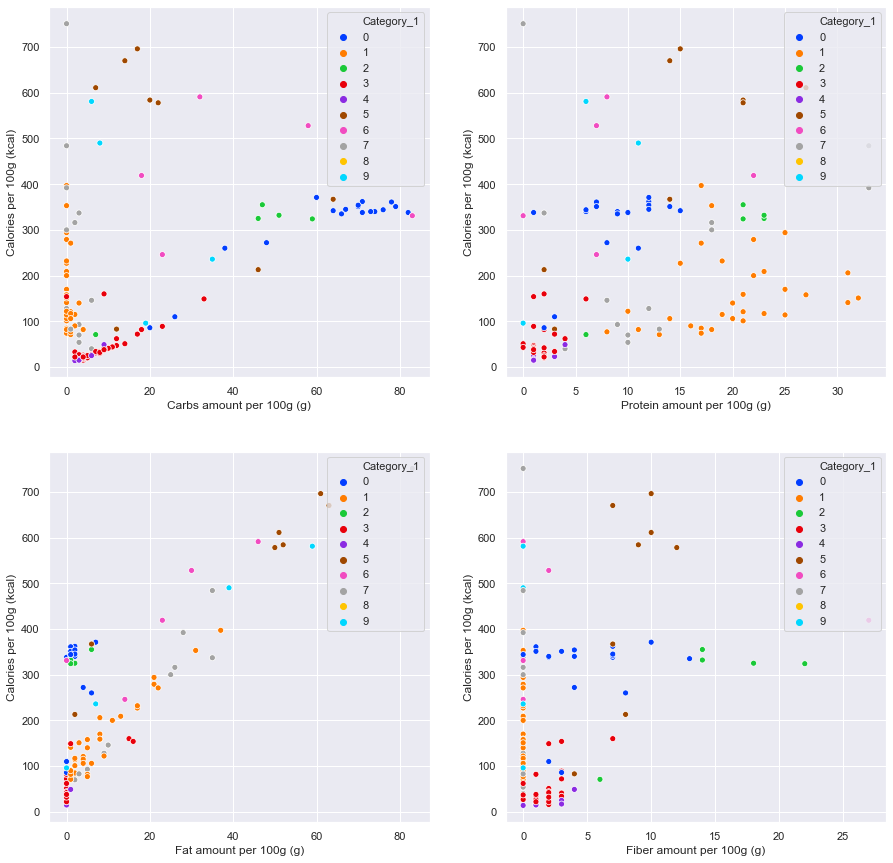

In [284]:
import seaborn as sns


food_categories = {0:'Carbs', 1:'Meats', 2:'Legumes', 3:'Fruits & Vegetables', 4:'Leaves & Salad', 5:'Seeds, nuts & cereals', 
                   6:'Sweets', 7:'Eggs, Milk & cheese', 8:'Fats', 9:'Others'}

current_palette = sns.color_palette('bright', 10)
ax = dict(zip(columns_dict.keys(), [0,0,0,0,0]))
#fig, ((ax['Carbs'], ax['Protein']), (ax['Fat'], ax['Fiber'])) = plt.subplots(2,2, figsize=(15,15))
fig, ((ax['Carbs'], ax['Protein']), (ax['Fat'], ax['Fiber'])) = plt.subplots(2,2, figsize=(15,15))
for column in columns_dict.keys():
    if column == 'Calories':
        continue
    else:
        ax[column] = sns.scatterplot(data=solid_foods, x=column, y='Calories', hue='Category_1', legend='full', palette=current_palette, ax=ax[column])
        ax[column].set(xlabel=(column + ' amount per 100g (g)'), ylabel='Calories per 100g (kcal)')
        #ax[columns].legend(loc='best')
        #ax[column].get_labels()

        #.legend(('Carbs', 'Meats', 'Legumes', 'Fruits & Vegetables', 'Leaves & Salad', 'Seeds, nuts & cereals', 'Sweets', 'Eggs, Milk & cheese', 'Fats', 'Others'), loc='upper right')

        #fig.legend(('Carbs', 'Meats', 'Legumes', 'Fruits & Vegetables', 'Leaves & Salad', 'Seeds, nuts & cereals', 'Sweets', 'Eggs, Milk & cheese', 'Fats', 'Others'), loc='best')



plt.show()

# for column in columns:
#     if column == 'Calories':
#         continue
#     else:
#         ax = sns.scatterplot(data=solid_foods, x=column, y='Calories', hue='Category_1', legend='full', palette=current_palette)
#         _=plt.xlabel(column + ' amount per 100g (g)')
#         _=plt.ylabel('Calories per 100g (kcal)')
#         _=plt.legend(bbox_to_anchor=(1.1, 0.8))
#     plt.show()





#fig, (ax1, ax2) = plt.subplots(1,2)
#ax1 = sns.scatterplot(data=solid_foods, x='Carbs', y='Calories', hue='Category_1', legend='full', palette='Set1_r')
#ax2 = sns.scatterplot(data=solid_foods, x='Protein', y='Calories', hue='Category_1', legend='full', palette='Set1_r')
#_=plt.ylabel('Calories per 100g (kcal)')
#_=plt.xlabel('Carbs per 100g (g)')

#plt.show()

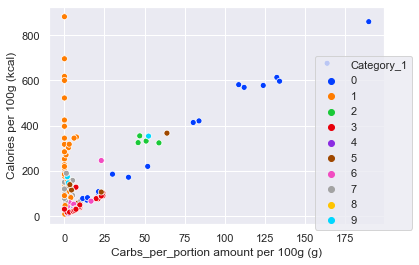

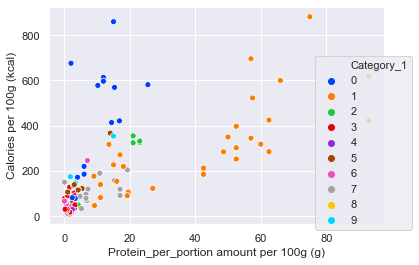

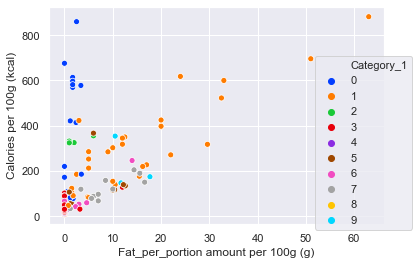

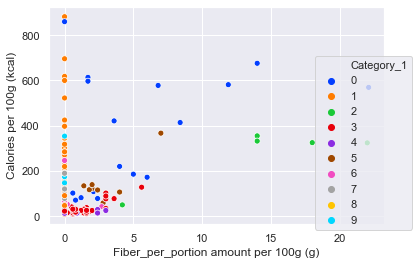

In [281]:
#print(solid_foods_portion.head())

columns_portion = ['Calories_per_portion', 'Carbs_per_portion', 'Protein_per_portion', 'Fat_per_portion', 'Fiber_per_portion']
for column in columns_portion:
    if column == 'Calories_per_portion':
        continue
    else:
        ax= sns.scatterplot(data=solid_foods_portion, x=column, y='Calories_per_portion', hue='Category_1', legend='full', palette=current_palette)
        _=plt.xlabel(column + ' amount per 100g (g)')
        _=plt.ylabel('Calories per 100g (kcal)')
        _=plt.legend(bbox_to_anchor=(1.1, 0.8))
        plt.show()
